## Dependence of the BF Effect on Neighboring Spots in Real Data/Simulation

Originally created by Alex Broughton


In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_14/conda/envs/lsst-scipipe-3.0.0-ext/eups 	setup
lsst_distrib          g4eaec17cb9+23bdaa02ee 	w_latest w_2022_14 current setup


In [2]:
# Helper functions
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt

def calc2ndMom(results):
    # Calculate Second Moments
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy

#### Galaxy @ 680nm, Flux 10^3 - 10^6

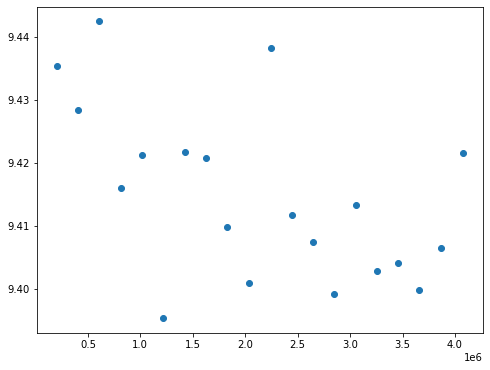

In [3]:
# model atmospheric turbulence as a VonKarman, with some small shear
#gprof = galsim.VonKarman(lam=1000.,r0=0.2,L0=10.0).shear(g1=0.06, g2=-0.05)

# add 4.5 microns sigma of Gaussian to model diffusion
# convert 4.5 microns to arcsec with factor 0.2"/10micron 
pixscale = 0.2/10.e-6
dprof = galsim.Gaussian(sigma=2.30677178e-6*pixscale)

# Airy function to simulate diffraction through mask
lam_over_diam = 0.00000475*(680./450.)  # radians
lam_over_diam *= 206265  # Convert to arcsec
airy = galsim.Airy(lam_over_diam)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile (returns instance of ChromaticObject)
chromatic_obj = galsim.Convolve([dprof,airy]) * sed


stamps = []
for n in range(20):

    # Select a single wavelength in nm (returns instance of GSObject)
    prof = chromatic_obj.evaluateAtWavelength(680.0).withFlux(305180*.91893*1.08*.93*1.08*1.006*.95 * (n+1)*(1/1.25))

    # add BF effect
    #sensor = galsim.SiliconSensor(strength = 1.4, diffusion_factor=1.75, nrecalc=1000)
    #sensor = galsim.SiliconSensor(strength = 1., diffusion_factor=1., nrecalc=1000)

    # draw image
    blank_image = galsim.Image(65*3,65*3,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
    star_image1 = prof.drawImage(image=blank_image, offset=(-65.,0), scale=0.2, method="phot", save_photons=True)
    star_image2 = prof.drawImage(image=star_image1, offset=(-65.,65.), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image3 = prof.drawImage(image=star_image2, offset=(0,65.), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image4 = prof.drawImage(image=star_image3, offset=(65.,65.), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image5 = prof.drawImage(image=star_image4, offset=(65.,0), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image6 = prof.drawImage(image=star_image5, offset=(65.,-65), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image7 = prof.drawImage(image=star_image6, offset=(0,-65), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image8 = prof.drawImage(image=star_image7, offset=(-65.,-65.), scale=0.2, method="phot", save_photons=True,add_to_image=True)
    star_image = prof.drawImage(image=star_image8, scale=0.2, method="phot", save_photons=True,add_to_image=True)

    temp = galsim.Image(star_image, dtype=star_image.dtype, copy=True)

    stamp = temp.subImage(galsim.BoundsI(temp.center.x - 33, temp.center.x + 33, temp.center.y - 33, temp.center.y + 33))
    stamps.append(galsim.Image(stamp.array))


# calculate HSM moments (these are in pixel coordinates)
sigmas = []
fluxes = []
for stamp in stamps:
    #mom = stamps[0].FindAdaptiveMom(weight=None, strict=False)
    results = stamp.FindAdaptiveMom()
    Ixx, Iyy, Ixy = calc2ndMom(results)
    sigmas.append(Ixx)
    fluxes.append(results.moments_amp)
    
    
# plot it
plt.figure(figsize=(8,6))
plt.scatter(fluxes, sigmas)

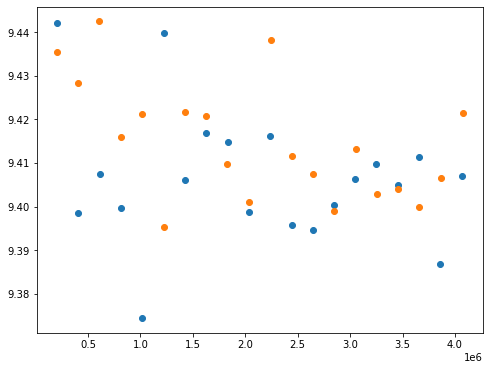

In [4]:
# model atmospheric turbulence as a VonKarman, with some small shear
#gprof = galsim.VonKarman(lam=1000.,r0=0.2,L0=10.0).shear(g1=0.06, g2=-0.05)

# add 4.5 microns sigma of Gaussian to model diffusion
# convert 4.5 microns to arcsec with factor 0.2"/10micron 
pixscale = 0.2/10.e-6
dprof = galsim.Gaussian(sigma=2.30677178e-6*pixscale)

# Airy function to simulate diffraction through mask
lam_over_diam = 0.00000475*(680./450.)  # radians
lam_over_diam *= 206265  # Convert to arcsec
airy = galsim.Airy(lam_over_diam)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile (returns instance of ChromaticObject)
chromatic_obj = galsim.Convolve([dprof,airy]) * sed


stamps = []
for n in range(20):

    # Select a single wavelength in nm (returns instance of GSObject)
    prof = chromatic_obj.evaluateAtWavelength(680.0).withFlux(305180*.91893*1.08*.93*1.08*1.006*.95 * (n+1)*(1/1.25))

    # add BF effect
    #sensor = galsim.SiliconSensor(strength = 1.4, diffusion_factor=1.75, nrecalc=1000)
    #sensor = galsim.SiliconSensor(strength = 1., diffusion_factor=1., nrecalc=1000)

    # draw image
    blank_image = galsim.Image(33,33,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
    star_image = prof.drawImage(image=blank_image, scale=0.2, method="phot", save_photons=True, add_to_image=True)

    stamps.append(galsim.Image(star_image.array))


# calculate HSM moments (these are in pixel coordinates)
sigmas_single = []
fluxes_single = []
for stamp in stamps:
    #mom = stamps[0].FindAdaptiveMom(weight=None, strict=False)
    results = stamp.FindAdaptiveMom()
    Ixx, Iyy, Ixy = calc2ndMom(results)
    sigmas_single.append(Ixx)
    fluxes_single.append(results.moments_amp)
    
    
# plot it
plt.figure(figsize=(8,6))
plt.scatter(fluxes_single, sigmas_single)
plt.scatter(fluxes, sigmas)
